In [1]:
import ExTRA as ex
from astropy.io import fits
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize


ExTRA  imported correctly


In [2]:
GAIA_EPOCH=Time('2017.5', format='jyear',scale="tcb")
GAIA_EPOCH_JY=GAIA_EPOCH.jyear
GAIA_EPOCH_JD=GAIA_EPOCH.jd

m1_MS = 0.76  # Primary star mass from paper Table 3
bh3_ra_deg = 294.8278502411 # Right Ascension from paper Table 2
bh3_dec_deg = 14.9309190720 # Declination from paper Table 2

lin.ra                         1.50624  ±  0.00708     
lin.dec                       -0.03341  ±  0.00674     
lin.parallax                   0.71520  ±  0.00871     
lin.mura                     -30.29679  ±  0.00477     
lin.mudec                   -148.62246  ±  0.00427 

In [3]:
#Gaia Single Star Solution
g_asc=bh3_ra_deg
g_dec=bh3_dec_deg
g_par=1.68 #mas
g_mua=-30.29679
g_mud=-148.62246
g_stand=np.array([g_asc,g_dec,g_par,g_mua,g_mud])

In [4]:
#read
rvdata=fits.open("data/GaiaBH3/bh3rv.fit")[1].data
astrodata=fits.open("data/GaiaBH3/bh3ast.fit")[1].data
#header
rv_names=rvdata.names[1:]
ast_names=astrodata.names

In [5]:
ast=[]
for name in ast_names:
    ast.append(astrodata.field(name))
ast=np.array(ast)
rv=[]
for name in rv_names:
    rv.append(rvdata.field(name))
rv=np.array(rv)

# Pre RV fit

In [6]:
def RV_fit(theta,data):

    v0,K,P,e,om,T0=theta

    t,d,err=data

    L=ex.L_RVs(t,d,err,0,v0,K,P,e,om,T0)
    return L

In [7]:
x0_rv=(-360,50,3850,0.5,0,GAIA_EPOCH_JD)
bnds_rv=(-500,500),(50,200),(3000,5000),(0,0.8),(-np.pi,np.pi),(GAIA_EPOCH_JD-10000,GAIA_EPOCH_JD+10000)

In [8]:
rvfit=minimize(RV_fit,x0_rv,args=(rv),bounds=bnds_rv,options={"maxiter":1e10},tol=1e-15)
print("v0,K,P,e,om,T0 : \n",rvfit.x)
print(rvfit.fun)

v0,K,P,e,om,T0 : 
 [-3.59261394e+02  5.75987122e+01  4.89401896e+03  7.68455814e-01
  1.30067567e+00  2.45815153e+06]
29.256838442968345


In [9]:
t_rvmod=np.linspace(rv[0][0],rv[0][-1],1000)
rv_check=ex.RV_mod(*rvfit.x,t_rvmod)

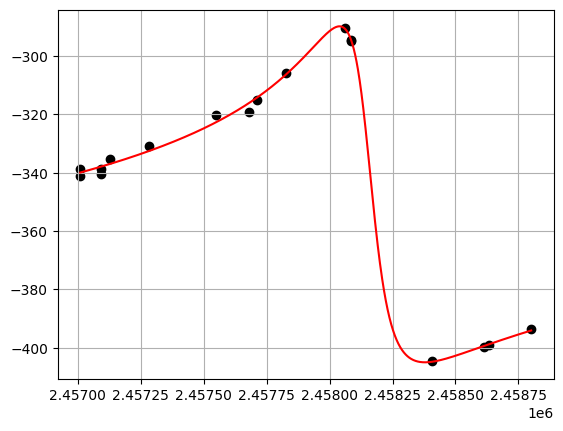

In [10]:
plt.plot(t_rvmod,rv_check,c="r")
plt.scatter(rv[0],rv[1],c="k")
plt.grid()
plt.show()

# Astrometric fit

In [11]:
relative_time=Time(ast[0], format='jd', scale='tcb').jyear-GAIA_EPOCH.jyear
gaia_angle=ex.angle_trafo(np.radians(ast[-1]))

t_gaia=ast[0]
A2=relative_time
A3=np.cos(gaia_angle)
A4=np.sin(gaia_angle)
A5=ast[3]
A6=A3*A2
A7=A4*A2
A8=ast[1]
A9=ast[2]
gaia=[A3,A4,A5,A6,A7,A8,A9]

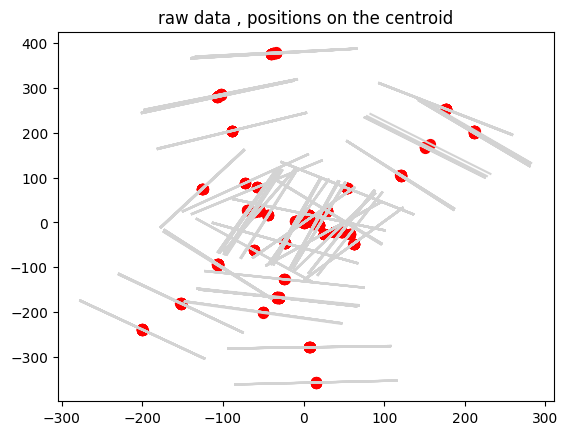

In [12]:
raw_2d=ex.hip_2d(gaia)
err_2d=np.array([raw_2d[1],raw_2d[3]])
ex.plot_hip(*raw_2d,size=100,s=50)
plt.title("raw data , positions on the centroid")
#plt.grid()
plt.show()

In [13]:
g_sss=ex.standard_model(*g_stand,t_gaia,ex.earth_position(t_gaia),tangential=True,Sepoch=GAIA_EPOCH_JD)

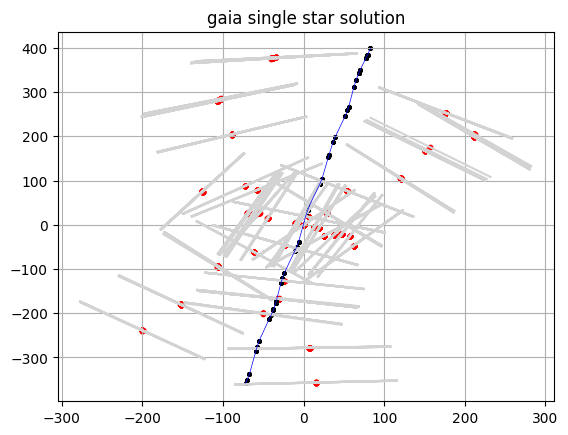

In [14]:
ex.plot_hip(*raw_2d,size=100,s=10)
plt.scatter(*g_sss,s=5,c="k")
plt.plot(*g_sss,c="b",linewidth=0.5)
#plt.axis("equal")
plt.title("gaia single star solution")
plt.grid()
plt.show()

In [15]:
planet_residual=ex.abs_res(A8,g_stand,np.array([g_asc,g_dec,0,0,0]),gaia)

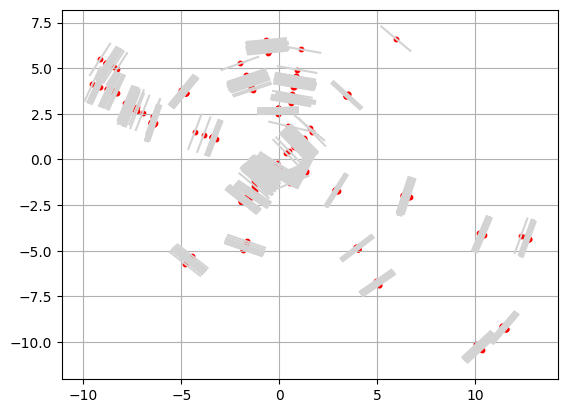

In [16]:
res_astrometric=np.copy(gaia)
res_astrometric[-2]=planet_residual

testing=ex.hip_2d(res_astrometric)


ex.plot_hip(*testing)

plt.grid()

In [17]:
#function you want to miniize
def gaia_min(theta,gaia_ad,gaia_s):

    P,e,om,i,Om,T0,a,del_asc,del_dec,del_para,del_mua,del_mud=theta
    #print(theta)

    correction=del_asc,del_dec,del_para,del_mua,del_mud

    L=ex.L_gaia(gaia_ad,gaia_s,correction,P,e,om,i,Om,T0,a)


    return L

4235.8 day
Eccentricity = 0.728
omega = 77.9 deg
Inclination  110.6 deg
OMEGA = 136.2 deg
T_periastron = 53941.2 day

In [18]:
P_g=4235.8
e_g=0.728
om_g=np.radians(77.9)
i_g=np.radians(110.6)
Om_g=np.radians(136.2)
T0_g=GAIA_EPOCH_JD
a_g=27.303
#guess
orb=np.array([P_g,e_g,om_g,i_g,Om_g,T0_g,a_g])
stand_corr=np.zeros(5)
x0=np.concatenate([orb,stand_corr])

In [40]:
#bounds
orbbnds=(P_g-1,P_g+1),(0.5,0.95),(-np.pi,np.pi),(0,2*np.pi),(-np.pi,np.pi),(T0_g-5000,T0_g+5000),(0,100)
standbnds=(-10,10),(-10,10),(-10,10),(-10,10),(-10,10)
bnds=orbbnds+standbnds

In [41]:
fit=minimize(gaia_min,x0,args=(res_astrometric,g_stand),bounds=bnds,tol=1e-10,method="Nelder-mead",options={"maxiter":1e5})
print(fit)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5573.765186131193
             x: [ 4.237e+03  7.309e-01  1.367e+00  1.925e+00  2.379e+00
                  2.458e+06  2.738e+01  1.172e-06  7.050e-07 -6.610e-02
                  1.983e+00 -6.610e+00]
           nit: 13068
          nfev: 17889
 final_simplex: (array([[ 4.237e+03,  7.309e-01, ...,  1.983e+00,
                        -6.610e+00],
                       [ 4.237e+03,  7.309e-01, ...,  1.983e+00,
                        -6.610e+00],
                       ...,
                       [ 4.237e+03,  7.309e-01, ...,  1.983e+00,
                        -6.610e+00],
                       [ 4.237e+03,  7.309e-01, ...,  1.983e+00,
                        -6.610e+00]], shape=(13, 12)), array([ 5.574e+03,  5.574e+03, ...,  5.574e+03,  5.574e+03],
                      shape=(13,)))


In [ ]:
print("om,i,Om:",np.degrees(fit.x[2:5])) 

om,i,Om: [ 78.83563365 109.25072718 137.24757409]


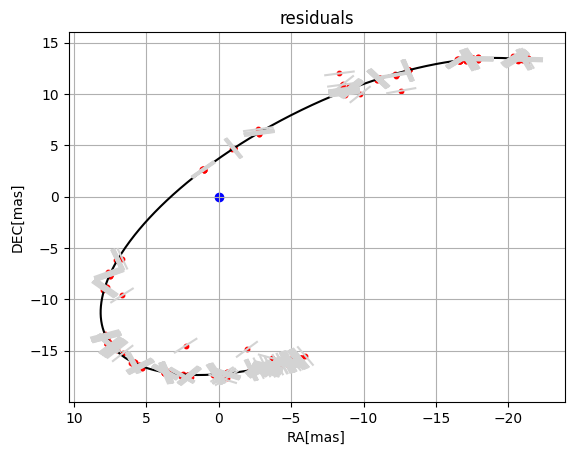

In [31]:
fit_residuals=ex.abs_res(planet_residual,fit.x[-5:],np.zeros(5),gaia[:5])

x_O,y_O=ex.orbit(*fit.x[:7],t_gaia)
    
res_gaia_final=fit_residuals-(A3*x_O+A4*y_O)

check=ex.res_to_orbit_gaia(res_gaia_final,gaia, fit.x[:7])


#ex.plot_hip(*ex.hip_2d(checking))

plt.title("residuals")
plt.ylabel("DEC[mas]")
plt.xlabel("RA[mas]")
plt.scatter(0,0,c="b")
plt.plot(*ex.orbit(*fit.x[:7],t_rvmod),c="k")
ex.plot_hip(*check)
plt.gca().invert_xaxis()
plt.grid()